In [52]:
import tensorflow as tf
import cv2
import numpy as np
import io
import time
import json
import base64
from PIL import Image
from matplotlib import pyplot as plt
from google.protobuf.json_format import MessageToJson
from collections import defaultdict

In [2]:
from __future__ import print_function
import io
import time
import json
import base64
from PIL import Image

In [3]:
# Utils from models/research/object_detection/
from utils import label_map_util
from utils import visualization_utils as vis_util
from utils import ops as utils_ops

C:\Users\Landscape\Anaconda3\envs\PythonDLCPU\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [31]:

def load_image_into_numpy_array(image_path):
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def draw_comparison_images(img1, img2):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
    ax1.imshow(img1)
    ax1.axis('off')
    ax1.set_title('Predicted')
    ax2.imshow(img2)
    ax2.set_title('Ground Truth')
    ax2.axis('off')
    plt.show()

In [32]:
class DeployedModel(object):
    def __init__(self, path_to_model, path_to_labels, num_classes):
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(path_to_model, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            
            self.label_map = label_map_util.load_labelmap(path_to_labels)
            self.categories = label_map_util.convert_label_map_to_categories(self.label_map, max_num_classes=num_classes, use_display_name=True)
            self.category_index = label_map_util.create_category_index(self.categories)
            
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)

    
    def predict_single(self, img_np):
        img_expanded = np.expand_dims(img_np, axis=0)  
        return self.predict_batch(img_expanded)
#         # Bounding Box Detection.
#         with self.detection_graph.as_default():
#             # Expand dimension since the model expects image to have shape [1, None, None, 3].
            
#             (boxes, scores, classes, num) = self.sess.run(
#                 [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
#                 feed_dict={self.image_tensor: img_expanded})
#         return {'boxes': boxes, 'scores': scores, 'classes': classes, 'num': num}
    
    def predict_batch(self, img_np):
        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_np})
        return {'boxes': boxes, 'scores': scores, 'classes': classes, 'num': num}
    
    def draw_visualize_prediction(self, img_np, boxes, classes, scores, threshold=0.1, fontsize=6):
        img_cp = img_np.copy()
#         img_expanded = np.expand_dims(img_np, axis=0)
        vis_util.visualize_boxes_and_labels_on_image_array(
            img_cp,
            boxes,
            classes,
            scores,
            self.category_index,
            use_normalized_coordinates=True,
            min_score_thresh=threshold,
            line_thickness=1,
            fontsize=fontsize)
        return img_cp

In [46]:
class Dataset(object):
    def __init__(self, ground_truth_record_files):
        self.data = defaultdict(dict)
        for ground_truth_record_file in ground_truth_record_files:
            for string_record in tf.python_io.tf_record_iterator(ground_truth_record_file):
                example = tf.train.Example()
                example.ParseFromString(string_record)
                this_file_dict = {}
                
                this_file_dict['filename'] = (example.features.feature['image/filename'].bytes_list.value[0].decode("utf-8") )
                this_file_dict['height'] = int(example.features.feature['image/height'].int64_list.value[0])
                this_file_dict['width'] = int(example.features.feature['image/width'].int64_list.value[0])
                this_file_dict['encoded_jpg'] = (example.features.feature['image/encoded'].bytes_list.value[0])
                this_file_dict['bbox_xmin'] = (example.features.feature['image/object/bbox/xmin'].float_list.value)
                this_file_dict['bbox_xmax'] = (example.features.feature['image/object/bbox/xmax'].float_list.value)
                this_file_dict['bbox_ymin'] = (example.features.feature['image/object/bbox/ymin'].float_list.value)
                this_file_dict['bbox_ymax'] = (example.features.feature['image/object/bbox/ymax'].float_list.value)
                this_file_dict['bbox'] = np.array([list(box) for box in zip(this_file_dict['bbox_ymin'], this_file_dict['bbox_xmin'], this_file_dict['bbox_ymax'], this_file_dict['bbox_xmax'])], dtype=float)
                this_file_dict['class_text'] = [text.decode("utf-8") for text in example.features.feature['image/object/class/text'].bytes_list.value]
                this_file_dict['class_label'] = list(example.features.feature['image/object/class/label'].int64_list.value)
                this_file_dict['label_num'] = len(this_file_dict['class_label'])
                this_file_dict['source_file'] = ground_truth_record_file
#                 encoded_jpg_io = io.BytesIO(this_file_dict['encoded_jpg'])
#                 image = Image.open(encoded_jpg_io)
#                 plt.imshow(image)
#                 print(this_file_dict['bbox'])
                self.data[this_file_dict['filename']] = this_file_dict
        
    def get_data_by_file_name(self, filename):
        return self.data[filename]
    
    def export_to_cloud_tfrecord_encoded_jpg(self, output_path, limit=10):
        order = 1
        with tf.python_io.TFRecordWriter(output_path) as tfr_writer:
            for img_name in sorted(self.data.keys()):
                print(img_name)
                img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
                img = img.resize((160, 160), Image.ANTIALIAS)
                output_str = io.BytesIO()

                img.save(output_str, "JPEG")
#                 fp.write(json.dumps({"b64": base64.b64encode(output_str.getvalue()).decode()}) + "\n")
                tfr_writer.write(output_str.getvalue())
                output_str.close()
                
#                 img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
#                 output_str = io.BytesIO()
#                 img.save(output_str, "JPEG")
#                 print(self.data[img_name]['label_num'])
#                 img_data = self.data[img_name]
#                 output_str = io.BytesIO(img_data['encoded_jpg'])

#                 d = base64.b64encode(output_str.getvalue())
#                 fp.write(json.dumps({"b64": d}) + "\n")
#                 output_str.close()
                order += 1
                
                if limit is not None and order > limit:
                    break
        
                
    def export_to_cloud_json_encoded_jpg(self, output_path, limit=10):
        order = 1
        with open(output_path, "w") as fp:
            for img_name in sorted(self.data):
                print(img_name)
                img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
                img = img.resize((160, 160), Image.ANTIALIAS)
                output_str = io.BytesIO()

                img.save(output_str, "JPEG")
                fp.write(json.dumps({"b64": base64.b64encode(output_str.getvalue()).decode()}) + "\n")
                output_str.close()
                
#                 img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
#                 output_str = io.BytesIO()
#                 img.save(output_str, "JPEG")
#                 print(self.data[img_name]['label_num'])
#                 img_data = self.data[img_name]
#                 output_str = io.BytesIO(img_data['encoded_jpg'])

#                 d = base64.b64encode(output_str.getvalue())
#                 fp.write(json.dumps({"b64": d}) + "\n")
#                 output_str.close()
                order += 1
                
                if order > limit:
                    break
    
    def export_to_cloud_json_image_tensor(self, output_path):
        order = 1
        with open(output_path, "w") as fp:
            for img_name in sorted(self.data.keys()):
                print(img_name)
                img_np = load_image_into_numpy_array("../../../data/images/adjusted/segmented/" + img_name)
#                 img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
#                 output_str = io.BytesIO()
#                 img.save(output_str, "JPEG")
#                 print(self.data[img_name]['label_num'])
#                 img_data = self.data[img_name]
#                 output_str = io.BytesIO(img_data['encoded_jpg'])

#                 d = base64.b64encode(output_str.getvalue()).decode('utf-8')
                fp.write(json.dumps({"inputs": img_np.tolist()}) + "\n")
#                 output_str.close()
                order += 1
                
                if order > 20:
                    break
                    
                    
                    

In [34]:
MODEL_PATH = "export3/frozen_inference_graph.pb"
PATH_TO_LABELS = "../../../data/dataset/label_map.pbtxt"
NUM_CLASSES = 6
# DATASET_NAMES = ["test_20180410.record", "train_20180410.record", "dev_20180410.record"]
DATASET_NAMES = ["test_20180410.record"]
DATASET_DIR = "../../../data/dataset/"
FONTSIZE=12

# data_lists['dev'] = [7, 12, 19, 24, 39, 47, 68, 76, 86, 100, 115]
# data_lists['test'] = [8, 20, 49, 67, 77, 85, 91, 117, 119]

In [53]:
image_names = ["117_0000_0000.JPG", "117_0000_0080.JPG", "117_0000_0160.JPG"]
full_evaluation = False
max_eval = 1

In [54]:
model = DeployedModel(MODEL_PATH, PATH_TO_LABELS, NUM_CLASSES)

In [47]:
dataset = Dataset([DATASET_DIR + dataset_name for dataset_name in DATASET_NAMES])


In [39]:
dataset.export_to_cloud_json_encoded_jpg(DATASET_DIR + "cloud_json_encoded_20180412_01.json", 3)

117_0000_0000.JPG
117_0000_0080.JPG
117_0000_0160.JPG


In [51]:
dataset.export_to_cloud_tfrecord_encoded_jpg(DATASET_DIR + "cloud_tfrecord_encoded_20180412_02.tfr", 25)

117_0000_0000.JPG
117_0000_0080.JPG
117_0000_0160.JPG
117_0000_0240.JPG
117_0000_0320.JPG
117_0000_0400.JPG
117_0000_0480.JPG
117_0000_0560.JPG
117_0000_0640.JPG
117_0000_0720.JPG
117_0000_0800.JPG
117_0080_0000.JPG
117_0080_0080.JPG
117_0080_0160.JPG
117_0080_0240.JPG
117_0080_0320.JPG
117_0080_0400.JPG
117_0080_0480.JPG
117_0080_0560.JPG
117_0080_0640.JPG
117_0080_0720.JPG
117_0080_0800.JPG
117_0160_0000.JPG
117_0160_0080.JPG
117_0160_0160.JPG


In [24]:
dataset.export_to_cloud_json_image_tensor(DATASET_DIR + "cloud_json_image_tensor_20180412_06.json")

117_0000_0000.JPG
117_0000_0080.JPG
117_0000_0160.JPG
117_0000_0240.JPG
117_0000_0320.JPG
117_0000_0400.JPG
117_0000_0480.JPG
117_0000_0560.JPG
117_0000_0640.JPG
117_0000_0720.JPG


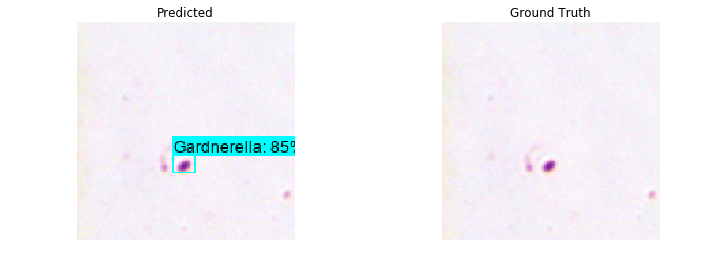

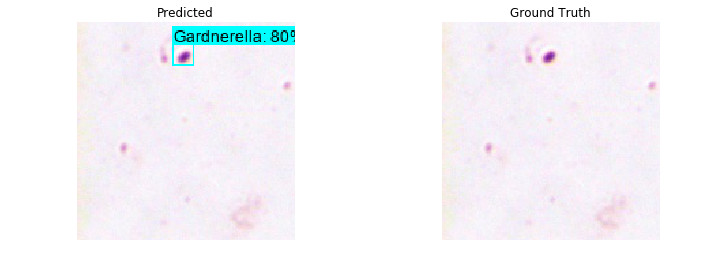

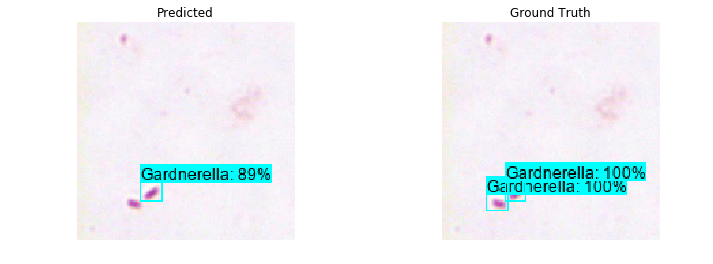

80.12641072273254


In [55]:
if full_evaluation:
    image_names = dataset.data

start = time.time()
eval_count = 0
for img_name in image_names:
    img_data = dataset.data[img_name]
    img_np = load_image_into_numpy_array(io.BytesIO(img_data['encoded_jpg']))
    pred = model.predict_single(img_np)
    img_pred = model.draw_visualize_prediction(img_np, pred['boxes'][0], pred['classes'][0].astype(np.uint8), pred['scores'][0],0.5, fontsize=FONTSIZE)
    img_truth = model.draw_visualize_prediction(img_np, img_data['bbox'], np.array(img_data['class_label'], dtype=np.uint8), np.full(img_data['label_num'], 1.0), fontsize=FONTSIZE)
    draw_comparison_images(img_pred, img_truth)
    eval_count += 1
    if full_evaluation and eval_count >= max_eval:
        break
done = time.time()
print(done - start)

In [74]:
import os
import h5py

In [77]:
A = np.array([1,2,3])

In [79]:
output_path = os.path.join(".", "test.record")

In [88]:
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [111]:
print(pred['scores'].shape, pred['scores'].dtype)


(1, 300) float32


In [114]:
with tf.python_io.TFRecordWriter(output_path) as writer:
    #     print(A.dumps())
    #     fid.write(A)
    height = 55
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': int64_feature(height),
        'ymin': float_list_feature(pred['boxes'][0,:,0]),
        'xmin': float_list_feature(pred['boxes'][0,:,1]),
        'ymax': float_list_feature(pred['boxes'][0,:,2]),
        'xmax': float_list_feature(pred['boxes'][0,:,3]),
        'classes': int64_list_feature(pred['classes'][0].astype(int)),
        'scores': float_list_feature(pred['scores'][0])
    }))
    writer.write(tf_example.SerializeToString())


In [115]:
for string_record in tf.python_io.tf_record_iterator(output_path):
    example = tf.train.Example()
    example.ParseFromString(string_record)
    print(example)

features {
  feature {
    key: "classes"
    value {
      int64_list {
        value: 2
        value: 2
        value: 1
        value: 3
        value: 6
        value: 6
        value: 3
        value: 6
        value: 1
        value: 3
        value: 4
        value: 5
        value: 5
        value: 5
        value: 4
        value: 5
        value: 4
        value: 4
        value: 4
        value: 3
        value: 5
        value: 2
        value: 5
        value: 5
        value: 6
        value: 4
        value: 1
        value: 4
        value: 5
        value: 5
        value: 3
        value: 4
        value: 5
        value: 6
        value: 6
        value: 6
        value: 3
        value: 1
        value: 4
        value: 3
        value: 4
        value: 3
        value: 2
        value: 5
        value: 6
        value: 5
        value: 4
        value: 4
        value: 6
        value: 4
        value: 2
        value: 5
        value: 1
        value: 3
        v

In [58]:
A = np.array([1,2,3])

In [59]:
print(A)

[1 2 3]


In [ ]:
with tf.python_io.TFRecordWriter(output_path) as tfr_writer:
            for img_name in sorted(self.data.keys()):
                print(img_name)
                img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
                img = img.resize((160, 160), Image.ANTIALIAS)
                output_str = io.BytesIO()

                img.save(output_str, "JPEG")
#                 fp.write(json.dumps({"b64": base64.b64encode(output_str.getvalue()).decode()}) + "\n")
                tfr_writer.write(output_str.getvalue())
                output_str.close()

In [176]:
if full_evaluation:
    image_names = dataset.data

start = time.time()
eval_count = 0
for img_name in image_names:
    img_data = dataset.data[img_name]
    img_np = DeployedModel.load_image_into_numpy_array(io.BytesIO(img_data['encoded_jpg']))
    pred = model.predict_single(img_np)
    img_pred = model.draw_visualize_prediction(img_np, pred['boxes'][0], pred['classes'][0].astype(np.uint8), pred['scores'][0],0.1, fontsize=FONTSIZE)
    img_truth = model.draw_visualize_prediction(img_np, img_data['bbox'], np.array(img_data['class_label'], dtype=np.uint8), np.full(img_data['label_num'], 1.0), fontsize=FONTSIZE)
    draw_comparison_images(img_pred, img_truth)
    eval_count += 1
    if full_evaluation and eval_count >= max_eval:
        break
done = time.time()
print(done - start)

AttributeError: type object 'DeployedModel' has no attribute 'load_image_into_numpy_array'

In [93]:
start = time.time()
img_names = list(image_names.keys())[0:5]
img_np = np.array([DeployedModel.load_image_into_numpy_array(io.BytesIO(dataset.data[img_name]['encoded_jpg'])) for img_name in img_names])
pred = model.predict_batch(img_np)
done = time.time()
print(done - start)

77.27611422538757


In [145]:
dataset.export_to_cloud_tfrecord_dataset(DATASET_DIR + "cloud_tfrecord_20180412_02.tfr")

117_0000_0000.JPG
117_0000_0080.JPG
117_0000_0160.JPG
2


# Python 2 Test

In [3]:
def export_to_cloud_json_encoded_jpg(img_names, output_path):
    order = 1
    with open(output_path, "wb") as fp:
        for img_name in sorted(img_names):

            img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
            print(img)
            img = img.resize((160, 160), Image.ANTIALIAS)
            output_str = io.BytesIO()
            
            img.save(output_str, "JPEG")
            fp.write(json.dumps({"b64": base64.b64encode(output_str.getvalue())}) + "\n")
            output_str.close()
#             img.save(output_str, "JPEG")
#             print(img_name)
# #                 img_data = self.data[img_name]
# #                 output_str = io.BytesIO(img_data['encoded_jpg'])
            
    
#             d = base64.b64encode(output_str.getvalue())
#             print(d[0])
#             fp.write(json.dumps({"b64": d}) + "\n")
#             output_str.close()
#             order += 1

#             if order >= 15:
#                 break

In [4]:
DATASET_DIR = "../../../data/dataset/"
image_names = ["117_0000_0000.JPG", "117_0000_0080.JPG", "117_0000_0160.JPG"]
export_to_cloud_json_encoded_jpg(image_names, DATASET_DIR + "p2_cloud_encode_json_20180412_01.json")

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x160 at 0x66E3A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x160 at 0x66E3B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x160 at 0x66E3C18>


# Python 3 Test

In [28]:
def export_to_cloud_json_encoded_jpg(img_names, output_path):
    order = 1
    with open(output_path, "w") as fp:
        for img_name in sorted(img_names):
            print(img_name)
            img = Image.open("../../../data/images/adjusted/segmented/" + img_name)
            img = img.resize((160, 160), Image.ANTIALIAS)
            output_str = io.BytesIO()
            
            img.save(output_str, "JPEG")
            fp.write(json.dumps({"b64": base64.b64encode(output_str.getvalue()).decode()}) + "\n")
            output_str.close()
#             img.save(output_str, "JPEG")
#             print(img_name)
# #                 img_data = self.data[img_name]
# #                 output_str = io.BytesIO(img_data['encoded_jpg'])
            
    
#             d = base64.b64encode(output_str.getvalue())
#             print(d[0])
#             fp.write(json.dumps({"b64": d}) + "\n")
#             output_str.close()
#             order += 1

#             if order >= 15:
#                 break

In [29]:
DATASET_DIR = "../../../data/dataset/"
image_names = ["117_0000_0000.JPG", "117_0000_0080.JPG", "117_0000_0160.JPG"]
export_to_cloud_json_encoded_jpg(image_names, DATASET_DIR + "p3_cloud_encode_json_20180412_01.json")

117_0000_0000.JPG
117_0000_0080.JPG
117_0000_0160.JPG


In [30]:
import json
data = []
with open(DATASET_DIR + "p3_cloud_encode_json_20180412_01.json",'r') as f:
    for line in f:
        data.append(json.loads(line))
# data = json.load(open(DATASET_DIR + "p3_cloud_encode_json_20180412_01.json"))

## DEPRECATED

In [28]:
def draw_bounding_boxes(img, boxes, scores, classes, threshold = 0.1):
    img_copy = np.array(img)
    img_size = img.size
    for i, box in enumerate(boxes[0]):
        if scores[0][i] >= threshold:
            cv2.rectangle(img_copy,
                (int(box[1] * img_size[0]), int(box[0] * img_size[1])),
                (int(box[3] * img_size[0]), int(box[2] * img_size[1])),
                (0,255,0))
    return img_copy

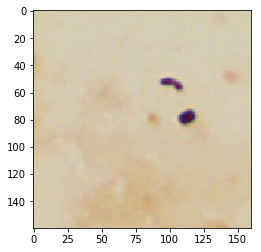

In [5]:
img = Image.open("../../../data/images/adjusted/segmented/1_0000_0000.JPG")
plt.imshow(img)

In [10]:
boxes, scores, classes, num = D.predict(img)

In [27]:
print(scores[0])

[ 0.05221449  0.03826071  0.03208167  0.03153662  0.02810484  0.02773206
  0.02555017  0.02515446  0.02421933  0.02311803  0.02108611  0.02099272
  0.02066787  0.02060007  0.01963248  0.01915266  0.01791956  0.01788784
  0.01754771  0.01706775  0.01705056  0.01680096  0.01636134  0.016125
  0.01584318  0.01551666  0.01544636  0.0154168   0.01494348  0.01434231
  0.01425896  0.01422123  0.01338605  0.01314044  0.01310444  0.01283841
  0.01273448  0.01264961  0.01253914  0.01251283  0.01242406  0.01240819
  0.01225696  0.01216425  0.01195443  0.01182668  0.01180651  0.01173978
  0.01156555  0.01151707  0.01151701  0.01148261  0.0114178   0.011306
  0.01129889  0.01128099  0.01121931  0.01119852  0.01111853  0.01086475
  0.01079339  0.01073917  0.010547    0.01043982  0.01038201  0.01028948
  0.01027853  0.01025908  0.01023676  0.01020483  0.01007948  0.00996547
  0.00969472  0.00949988  0.00942629  0.00923272  0.00906491  0.00899931
  0.00899077  0.00897457  0.00893834  0.00881237  0.008

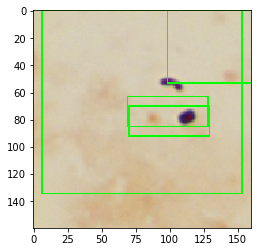

In [31]:
plt.imshow(draw_bounding_boxes(img, boxes, scores, classes, 0.03))